In [1]:
import numpy as np
import pandas as pd
import matplotlib as mpl 
import matplotlib.pyplot as plt

import json
import os
import re
import torch

from collections import Counter, defaultdict
from itertools import islice

%matplotlib inline

In [2]:
def get_results(
                version:str='train',
                model:str='linear',
                task_setting:str='single',
):
    subdir = './results_train/' if version == 'train' else './results_test/'
    subsubdir =  subdir + model + '/' + task_setting + '/' 
    all_files = list(map(lambda f: subsubdir + f, os.listdir(subsubdir)))
    all_results = defaultdict(dict)
    for file in all_files: #islice(all_files, 1, None):
        if not re.search(r'.ipynb_checkpoints', file):
            with open(file) as f:
                r = json.load(f)
                for metric, values in r.items():
                    all_results[file][metric] = values
    return dict(all_results)

  
def plot_results(
                 results:dict,
                 metric:str,
                 model:str,
                 task_setting:str,
                 iv:str='datasets',
                 correlation:bool=False,
):
    r_plot = {}
    for clf, r in results.items():
        for m, v in r.items():
            if re.search(r'' + metric, m):
                r_plot[clf] = v
    
    #if iv == 'optims':
    #    params = ['AdamW', 'Adam', 'SGDCos', 'SGD']
    if iv == 'datasets':
        params = ['$D_o \cup D_s$', '$D_o$', '$D_s$']
    
    if re.search(r'batch_loss', metric):
        plt.figure(figsize=(10, 6), dpi=100)
    
    for idx, (clf, met) in enumerate(r_plot.items()):
        plt.plot(range(1, len(met) + 1), met, '-o', label=params[idx])
    
    if re.search(r'acc', metric): 
        plt.ylabel('Exact-match', fontsize=12)
    
    elif re.search(r'f1', metric):
        plt.ylabel('F1', fontsize=12)
    
    elif re.search(r'loss', metric):
        plt.yticks(range(1, 7))
        plt.ylabel('Loss', fontsize=12)
    
    plt.xlabel('Evaluation steps', fontsize=12) 
    plt.legend(fancybox=True, shadow=True)
    plt.savefig('./plots/' + 'models/' + model + '/' + task_setting + '/ '+ metric + '.png')
    plt.show()
    
def plotting(
             models:list,
             metrics:list,
             version:str,
             task_setting:str,
             iv:str,
):
    # load results
    for i, model in enumerate(models):
        all_results = get_results(version=version, model=model, task_setting=task_setting)
        print('------------------------------')
        print('------- Model: {} --------'.format(model.upper()))
        print('------------------------------')
        print()
        for j, metric in enumerate(metrics):
            print('-------------------------------')
            print('----- Metric: {} -----'.format(metric.upper()))
            print('------------------------------')
            plot_results(all_results, metric=metric, iv=iv,  model=model, task_setting=task_setting)

In [3]:
# specify general hyperparameters
models = ['linear', 'highway', 'recurrent']
metrics = ['batch_loss', 'batch_acc', 'batch_f1', 'val_f1', 'val_acc', 'val_loss']

version = 'train'
task_setting ='single'
iv = 'datasets'

------------------------------
------- Model: LINEAR --------
------------------------------

-------------------------------
----- Metric: BATCH_LOSS -----
------------------------------


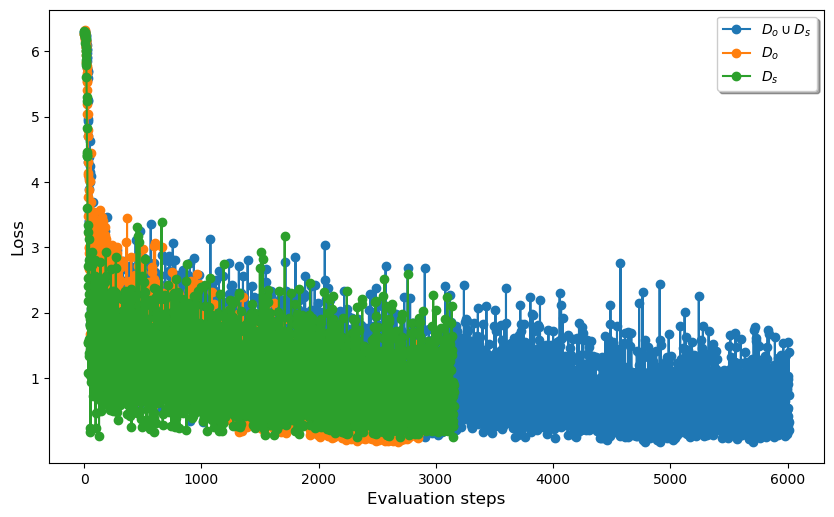

-------------------------------
----- Metric: BATCH_ACC -----
------------------------------


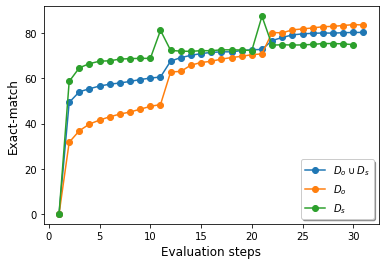

-------------------------------
----- Metric: BATCH_F1 -----
------------------------------


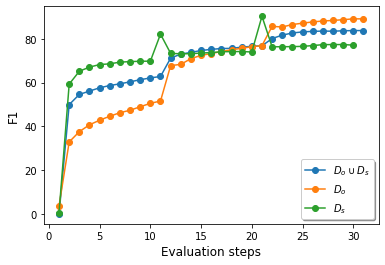

-------------------------------
----- Metric: VAL_F1 -----
------------------------------


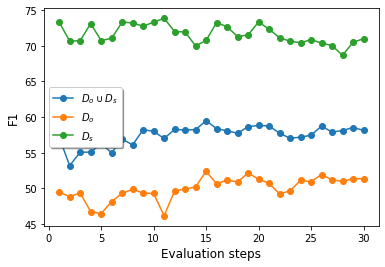

-------------------------------
----- Metric: VAL_ACC -----
------------------------------


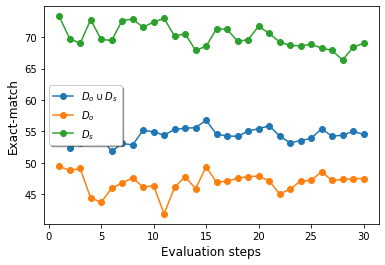

-------------------------------
----- Metric: VAL_LOSS -----
------------------------------


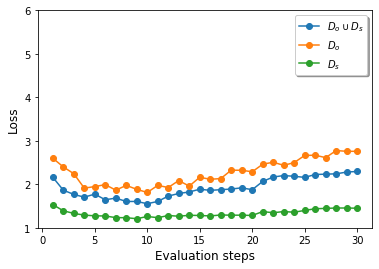

------------------------------
------- Model: HIGHWAY --------
------------------------------

-------------------------------
----- Metric: BATCH_LOSS -----
------------------------------


In [ ]:
plotting(models=models, metrics=metrics, version=version, task_setting=task_setting, iv=iv)